# Housing Market Forecasting Using Neural Networks

Purchasing or selling a house is a major financial decision. Home prices vary based on factors such as square footage and location, but they also fluctuate seasonally. To add a layer of complexity, they are also influenced by a number of other factors that are difficult to predict, such as a global pandemic leading to large population shifts [1] or rapid interest rate increases making mortgages less affordable [2]. The goal of this project is to lay the groundwork to use deep learning to make short-term housing price predictions, 1 month out, based on publicly available time series data that is routinely measured. The thinking is that even the most current housing data lags by about a month, so a precise one-month estimate could give someone a better reflection of the value of the home they wish to buy/sell. In turbulent markets, accurate short-term predictions could be beneficial to buyers and sellers for several reasons.

* Benefits to sellers:
  * If home values are decreasing and a home is priced too high because of a downward shift in the market, it might sit on the market and increase the current owners' holding costs.
  * If home values are increasing, the homeowner might list their home for less than what they could have gotten for it.

* Benefits to buyers:
  * If home values are decreasing and a buyer puts in an offer that is too high, they may be paying more for the home than necessary. Even if they can afford the offer price with their current down payment, if the home does not appraise at the offer price, they may have to put more money down to close or look for a different property.
  * If home prices are trending upward, buyers run the risk of not getting their offers accepted if they are putting in offers that are low.

You can access this notebook and all CSV files used for the project from my GitHub repository [here](https://github.com/arwhit/housing-market-forcasting-NN).

Details about how the Zillow datasets are produced and access to the most up-to-date data can be found [here](https://www.zillow.com/research/data/).

A comprehensive list of sources is provided at the end of the notebook.

In [86]:
#Import Libraries and Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import keras
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense, Dropout, Activation
import tensorflow as tf

## Data Description

If you have been reviewing other projects hosted on my GitHub, these datasets will probably look familiar to you. I have used similar datasets for projects involving Decision Tree classification and Principal Component Analysis in the past. If this is your first time seeing the Zillow datasets [3], here is a summary:

**Home Values (HV)**:

* This dataset is composed of historical monthly prices from February 1996 to July 2023, 330 months (columns) for 894 metro areas (rows).
* In total, the dataset contains 246,014 time series data points and 49,006 missing values.
* The dataset also contains five categorical columns:
    * RegionID
    * SizeRank
    * RegionName
    * RegionType
    * StateName

**Days to Pending (DTP)**:

* This dataset is composed of historical monthly data for 773 metro areas (rows) from January 2018 to July 2023, 67 months (columns).
* In total, the dataset contains 34,611 time series data points and 17,180 missing values.
* The dataset also contains five categorical columns:
    * RegionID
    * SizeRank
    * RegionName
    * RegionType
    * StateName

**Inventory (INV)**:

* This dataset contains historical monthly inventory data for 927 metro areas (rows) from January 2018 to July 2023, 67 months (columns).
* In total, the dataset contains 60,850 time series data points and 1,259 missing values.
* The dataset also contains five categorical columns:
    * RegionID
    * SizeRank
    * RegionName
    * RegionType
    * StateName

**Sales to List Price Ratio (STL)**:

* This dataset contains the monthly sell to list price ratio for 520 metro areas (rows) from January 2018 to June 2023, 66 months (columns).
* In total, the dataset contains 25,114 time series data points and 9,206 missing values.
* The dataset also contains five categorical columns:
    * RegionID
    * SizeRank
    * RegionName
    * RegionType
    * StateName

It is important to note that the Zillow Home Value Index is itself an estimate, but is arguably the most comprehensive and data driven estimate publically available. For the purposes of this project, it will be assumed to be the actual market value.

In [87]:
#Import Data
#Home Values
hv_url='https://raw.githubusercontent.com/arwhit/housing-market-forcasting-NN/main/Metro_ZHVI_AUG_14th_23.csv'
hv_df=pd.read_csv(hv_url)
hv_missing=hv_df.isna().sum().sum()
#Days to pending data
dtp_url='https://raw.githubusercontent.com/arwhit/housing-market-forcasting-NN/main/Metro_Mean_DTP_AUG_14th_23.csv'
dtp_df=pd.read_csv(dtp_url)
dtp_missing=dtp_df.isna().sum().sum()
# Sale to List Price Ratio
stl_url='https://raw.githubusercontent.com/arwhit/housing-market-forcasting-NN/main/Metro_Mean_STL_AUG_14th_23.csv'
stl_df=pd.read_csv(stl_url)
stl_missing=stl_df.isna().sum().sum()
#Inventory
inv_url='https://raw.githubusercontent.com/arwhit/housing-market-forcasting-NN/main/Metro_FS_Inventory_AUG_14th_23.csv'
inv_df=pd.read_csv(inv_url)
inv_missing=inv_df.isna().sum().sum()


## Data Cleaning
We need to do a little bit of cleaning up before we do any meaningful exploratory data analysis. For this project, we are only going to look at home values in the New York City Metro area. The US average and all other metro areas will be dropped.

The sales to list ratio dataset trails the other datasets by one month, so the July 2023 data will be dropped.

The monthly data from February 1996 to December 2017 will be dropped from the HV dataset since the monthly data from the other datasets is not available for that time period.

Lastly, we will merge everything into one dataframe and preview what it looks like.

In [88]:
#Clean Datasets

#drop columns that will not be used, also drop monthly data not in all datasets
hv_df.drop(['RegionID','RegionName','SizeRank','RegionType','StateName','2023-07-31'], axis=1, inplace=True)
begin_drop=hv_df.columns.get_loc('1996-02-29')
end_drop=hv_df.columns.get_loc('2017-12-31')
hv_df.drop(hv_df.columns[begin_drop:(end_drop+1)], axis=1, inplace=True)
dtp_df.drop(['RegionID','RegionName','SizeRank','RegionType','StateName','2023-07-31'], axis=1, inplace=True)
inv_df.drop(['RegionID','RegionName','SizeRank','RegionType','StateName','2023-07-31'], axis=1, inplace=True)
stl_df.drop(['RegionID','RegionName','SizeRank','RegionType','StateName'], axis=1, inplace=True)

#Retain Only NYC Data
HV=hv_df.iloc[1]
DTP=dtp_df.iloc[1]
INV=inv_df.iloc[1]
STL=stl_df.iloc[1]

#Combine Datasets
df = pd.concat([HV, DTP, INV, STL], keys=['HV', 'DTP', 'INV', 'STL'], axis=1)
df = df.reset_index().rename(columns={'index': 'Date'})
df.head()

,Date,HV,DTP,INV,STL
0,2018-01-31,434168.607328,73.0,66530.0,0.975376
1,2018-02-28,433237.046452,68.0,74575.0,0.975660
2,2018-03-31,435337.236215,63.0,80016.0,0.978424
3,2018-04-30,438264.586329,65.0,86445.0,0.982775
4,2018-05-31,442892.804380,62.0,91131.0,0.980287


## EDA

Now let's take a look at the cleaned dataset we are working with. First, let's make sure there are no missing values that we need to impute.


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    66 non-null     object 
 1   HV      66 non-null     float64
 2   DTP     66 non-null     float64
 3   INV     66 non-null     float64
 4   STL     66 non-null     float64
dtypes: float64(4), object(1)
memory usage: 2.7+ KB


We see that we have 66 months of observances with zero missing values. Let's explore the breakdown of values in each column a little further.

In [90]:
df.describe()

,HV,DTP,INV,STL
count,66.000000,66.000000,66.000000,66.000000
mean,515165.345242,73.772727,70316.878788,0.993652
std,56835.135944,16.434294,15942.065775,0.016513
min,433237.046452,44.000000,41911.000000,0.973832
25%,465502.679313,62.250000,59479.250000,0.979804
50%,498583.147883,70.500000,70586.000000,0.991389
75%,567278.547601,85.000000,82744.250000,1.005476
max,615770.908693,115.000000,98511.000000,1.034933


We can see that the magnitudes of the input variables are largely different, meaning we will need to scale the input data to get meaningful results. Let's also plot how each variable is changing over time.

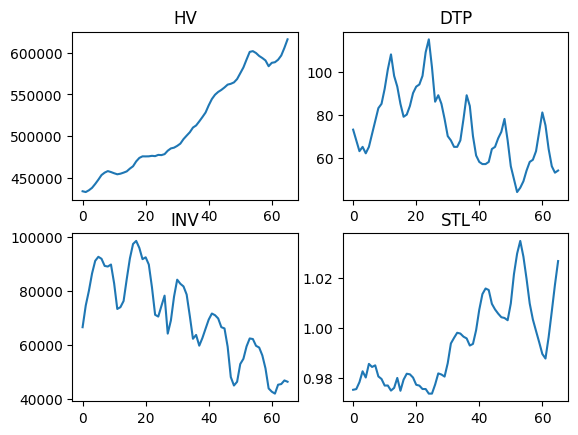

In [91]:
fig, axes = plt.subplots(nrows=2, ncols=2)

# Plot the lines
axes[0,0].plot(df['HV'])
axes[0,1].plot(df['DTP'])
axes[1,0].plot(df['INV'])
axes[1,1].plot(df['STL'])

# Set the titles
axes[0,0].set_title('HV')
axes[0,1].set_title('DTP')
axes[1,0].set_title('INV')
axes[1,1].set_title('STL')
plt.show()

The overall inventory and days to pending appear to be trending downward over the measured period, while the home value and sales to list ratio appear to trend upwards. There is a large amount of seasonality in days to pending, inventory, and the sales to list ratio. There also appears to be a small amount of seasonality in the housing price, but it is not as pronounced.

## Data Preprocessing

Let's create a time of year signal so the algorithm can learn to distinguish between the summer months when the real estate market appears to be at its peak and the off months when less transactions appear to be going on. There is a clever trick discussed in a TensorFlow tutorial [4] that goes into detail on how to do this.


In [92]:
#Extract Date and Convert to Timestamp Object
date_time = pd.to_datetime(df.pop('Date'), format='%Y-%m-%d')
#Convert to Seconds
timestamp_s = date_time.map(pd.Timestamp.timestamp)
#Create the signal and append to the dataframe
day = 24*60*60
year = (365.2425)*day
df['Month Signal'] = np.cos(timestamp_s * (2 * np.pi / year))

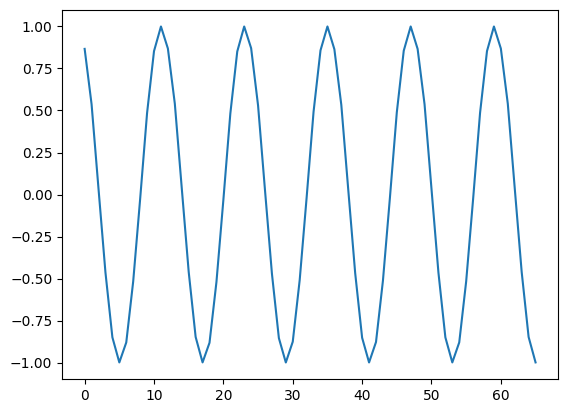

In [93]:
#Visualize results
plt.plot(df['Month Signal'])

The data will be split before being passed into the model. This will help to prevent overfitting. Since this is time series data for one metro area, shuffling the data is probably not the best approach, but we will still do a 70/20/10 split. We also need to normalize the data so that input variables on a larger scale do not wash out features on a smaller scale. In an effort to prevent unrealistic results, the normalization will only be based on the training data.



In [94]:
#Split the Data
n = len(df)
raw_train_df = df[0:int(n*0.7)]
raw_val_df = df[int(n*0.7):int(n*0.9)]
raw_test_df = df[int(n*0.9):]
#Normalize the Data based on Training Data Only
train_mean = raw_train_df.mean()
train_std = raw_train_df.std()
train_df = (raw_train_df - train_mean) / train_std
val_df = (raw_val_df - train_mean) / train_std
test_df = (raw_test_df - train_mean) / train_std

In [95]:
train_df.head()

,HV,DTP,INV,STL,Month Signal
0,-1.422555,-0.409728,-1.103028,-0.921109,1.287869
1,-1.449373,-0.734684,-0.363651,-0.897962,0.817909
2,-1.388913,-1.059641,0.136405,-0.672688,0.100357
3,-1.304640,-0.929658,0.727264,-0.317953,-0.608855
4,-1.171403,-1.124632,1.157932,-0.520788,-1.158884


Let's take one last look at the dataset before and after normalization to visualize what has happened to the data.

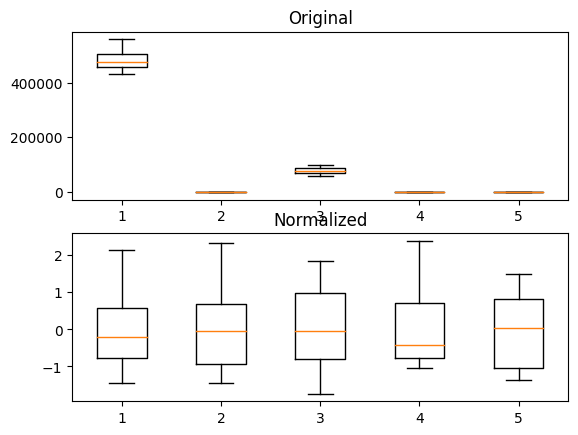

In [96]:
#Plot the original and normalized data
fig, axes = plt.subplots(nrows=2, ncols=1)

# Plot the lines
axes[0].boxplot(raw_train_df)
axes[1].boxplot(train_df)

# Set the titles
axes[0].set_title('Original')
axes[1].set_title('Normalized')

plt.show()

We can see from the plot the effect of normalization. The variables are still not perfectly distributed and still have a few outliers, but are all on the same scale.

Lastly, we will make sure the data is shaped properly and is formatted for the task we are attempting. TensorFlow expects the following format for time series data: *(batch size, time step, features)*. We will also need to specify the "window" of timesteps to look at to make the predictions. This window will need to shift as we make a prediction so that it uses the most recent "seen" timesteps to train the model and make the predictions. There is a nice WindowGenerator class in the TensorFlow timeseries tutorial [4] that we will implement to shape the data.


In [168]:
#Create WindowGenerator Class
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    #Make results replicable
    keras.utils.set_random_seed(5)
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}
    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift
    self.total_window_size = input_width + shift
    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]
    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

#Create Split Window Method
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)
  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])
  return inputs, labels
WindowGenerator.split_window = split_window

#Create method to make the dataset
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=1,)
  ds = ds.map(self.split_window)
  return ds
WindowGenerator.make_dataset = make_dataset

@property
def train(self):
  return self.make_dataset(self.train_df)
@property
def val(self):
  return self.make_dataset(self.val_df)
@property
def test(self):
  return self.make_dataset(self.test_df)
@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [169]:
#Create the Windows to be Used
window=WindowGenerator(input_width=1, label_width=1, shift=1, label_columns=['HV'])

## Model Building

Three models will be built for testing:

1. **Baseline model:** This model outputs the previous month's home value. This model represents the current methodology used to price a house based on recent comparable sales, making no adjustments for projected future trends.
2. **LSTM model:** This model implements a Long Short-Term Memory (LSTM) layer, which is a type of recurrent neural network. RNNs can suffer from vanishing gradients, which can lead to suboptimal results. LSTM was developed as a type of RNN to combat the vanishing gradient problem. The LSTM approach adds a cell state output in addition to the hidden layer output that is passed to the next time step. The cell state is meant to help with "long-term" memory. Inside the LSTM, there are four gates that perform operations on the input: forget, input, gate, and output.
3. **GRU model:** This model implements a Gated Recurrent Unit (GRU) layer, which is another type of recurrent neural network that is meant to mitigate vanishing gradients due to "memory loss." The GRU model is newer than the LSTM approach and does not require tracking previous cell state. There are only three gates within the GRU cell: reset, gate, and z. There is no cell state output. Instead, the output of the hidden layer is more of a rolling average containing a contribution from the current time step and a contribution from all previous time steps.

(The LSTM and GRU approaches can be difficult concepts to visualize. I have included a link [5] in the sources section that offers some very insightful illustrations.)

**Hyperparameter tuning:** The main hyperparameter being tuned is the architecture itself (LSTM vs GRU). I also experimented with different numbers of nodes in each layer (16-256), tried multiple RNN layers, and added additional dense layers before the final output layer. The best results are shown below.

All predictions will be for the next month only


In [170]:
val_performance = {}
test_performance = {}
train_preds={}
val_preds={}
test_preds={}

#Basline Model
def base_pred(df):
  vals=df['HV'].tolist()
  true_vals=[]
  pred_vals=[]
  for i in range(1,len(vals)):
    true_vals.append(vals[i])
    pred_vals.append(vals[i-1])
  true_vals=pd.Series(true_vals)
  pred_vals=pd.Series(pred_vals)
  MSE=sum((true_vals-pred_vals)**2)/len(vals)
  MAE=sum(true_vals-pred_vals)/len(vals)
  return [MSE, MAE], pred_vals
base_train=base_pred(train_df)
base_val=base_pred(val_df)
base_test=base_pred(test_df)

val_performance['Baseline']=base_val[0]
test_performance['Baseline']=base_test[0]
train_preds['Baseline']=base_train[1].tolist()
val_preds['Baseline']=base_val[1].tolist()
test_preds['Baseline']=base_test[1].tolist()


#LSTM
lstm_model=Sequential([
    LSTM(256, return_sequences=True),
    Dense(1)
])
#Compile
lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

#Fit the model to the training data
stop_criteria = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=20, mode='min')
lstm_history=lstm_model.fit(window.train, epochs=200, validation_data=window.val, callbacks=[stop_criteria], verbose=0)
print('The LSTM model stopped after ',len(lstm_history.history['val_loss']),' epochs')
#Capture Results
val_performance['LSTM'] = lstm_model.evaluate(window.val, verbose=0)
test_performance['LSTM'] = lstm_model.evaluate(window.test, verbose=0)
train_preds['LSTM']=lstm_model.predict(window.train, verbose=0).flatten().tolist()
val_preds['LSTM']=lstm_model.predict(window.val, verbose=0).flatten().tolist()
test_preds['LSTM']=lstm_model.predict(window.test, verbose=0).flatten().tolist()

#GRU
GRU_model=Sequential([
    GRU(128, return_sequences=True),
    Dense(1)
])
#Compile
GRU_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])
#Fit the model to the training data
stop_criteria = tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=20, mode='min')
GRU_history=GRU_model.fit(window.train, epochs=200, validation_data=window.val, verbose=0)
print('The GRU model stopped after ',len(GRU_history.history['val_loss']),' epochs')
#Capture Results
val_performance['GRU'] = GRU_model.evaluate(window.val, verbose=0)
test_performance['GRU'] = GRU_model.evaluate(window.test, verbose=0)
train_preds['GRU']=GRU_model.predict(window.train, verbose=0).flatten().tolist()
val_preds['GRU']=GRU_model.predict(window.val, verbose=0).flatten().tolist()
test_preds['GRU']=GRU_model.predict(window.test, verbose=0).flatten().tolist()

The LSTM model stopped after  59  epochs
The GRU model stopped after  200  epochs


## Results and Analysis
As previously stated in the model building section, several hyperparameters were tuned, and the best performing models of each architecture were retained for the report. Let's plot the mean absolute error (MAE). To make the results less ambiguous, we will convert the metrics back to dollar values before constructing the plot.

Text(0.5, 1.0, 'MAE Performance')

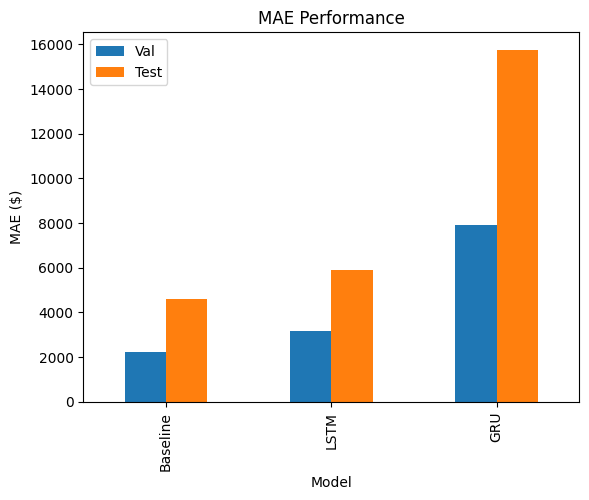

In [171]:
#Create MAE Dataframe
models=list(val_performance.keys())
MAE_val=[]
MAE_test=[]
for model in models:
  MAE_val.append(val_performance[model][1])
  MAE_test.append(test_performance[model][1])
MAE=pd.DataFrame({'Model':models, 'Val':MAE_val, 'Test':MAE_test})
#Convert Units back to dollars
MAE['Val']=(MAE['Val']*train_std['HV'])
MAE['Test']=(MAE['Test']*train_std['HV'])
#Construct the Plot
MAE.plot(x='Model', y=['Val', 'Test'], kind='bar')
plt.xlabel("Model")
plt.ylabel("MAE ($)")
plt.title("MAE Performance")

Interestingly, the base model appears to slightly outperform the best LSTM model, and the best GRU model performs the worst. This highlights that deep learning is not magic. Sometimes a simpler solution is just as good, if not better, than a more complex one. I suspect that if we were to try to project out multiple months instead of just 1, the results might differ. However, that was not the goal of the project, and I do not want to manipulate the experiment to produce the results I expected.

Let's also plot predictions vs. months.

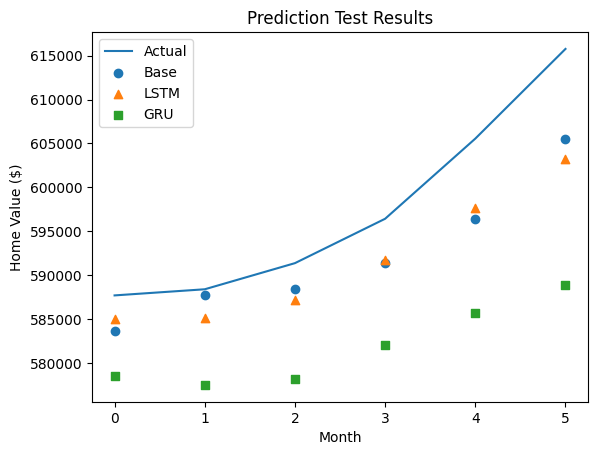

In [183]:
preds=[]
actual=test_df['HV'].values[1:]
for model in models:
  preds.append(test_preds[model])
results=pd.DataFrame({'Actual': actual, 'Base':preds[0], 'LSTM':preds[1], 'GRU':preds[2]})
#Convert Units back to dollars
results=(results*train_std['HV'])+train_mean['HV']
x = results.index.values
plt.plot(x, results['Actual'], label='Actual')
plt.scatter(x, results['Base'], marker="o", label='Base')
plt.scatter(x, results['LSTM'], marker="^", label='LSTM')
plt.scatter(x, results['GRU'], marker="s", label='GRU')

plt.xlabel('Month')
plt.ylabel('Home Value ($)')
plt.legend()
plt.title('Prediction Test Results')
plt.show()

## Conclusion and Future Work
Using neural networks to predict housing market trends is certainly possible, but it does not outperform the previous month estimate, which is the current solution, for our dataset. It is also important to note that neural networks, while still technically supervised learning, are less interpretable than other supervised methods and are harder to extract explanatory meaning from the model. In other words, if the only goal is to predict a future price, neural networks are a powerful tool. However, if the goal is to explain in more detail how the individual input variables affect the market price, other approaches may be more effective.

If I were to develop this project further, I would experiment with making predictions for slightly longer periods, such as 3-6 months out. I would also work to develop a generic model that is not based on a single metro area. I would incorporate categorical variables such as the state, metro area, and metro size into the model. I would also experiment with different architectures that have a combination of convolutional neural network (CNN) and recurrent neural network (RNN) layers, like what is discussed by the authors of the paper "LSTM Fully Convolutional Networks for Time Series Classification" [6]. The CNN layers would be used to learn longer-term trends associated with the specific states and metro areas. The RNN layer would be similar to what was already produced here. I might also try to add more features, such as rental prices/inventory or overall sentiment regarding a metro area.

### Sources

1. https://www.zillow.com/research/data/

2. https://www.census.gov/library/stories/2022/05/population-shifts-in-cities-and-towns-one-year-into-pandemic.html

3. https://www.huduser.gov/portal/pdredge/pdr-edge-featd-article-022123.html

4. https://www.tensorflow.org/tutorials/structured_data/time_series

5. https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

6. https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8141873